- Notebook modified from https://www.kaggle.com/code/markwijkhuizen/planttraits2024-eda-training-pub.
- Training only, EDA part not included.
- Image model only, tabular data not used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

import torch
import timm
import glob
import torchmetrics
import time
import psutil
import os

tqdm.pandas()

In [2]:
class Config():
    IMAGE_SIZE = 384
    BACKBONE = 'swin_large_patch4_window12_384.ms_in22k_ft_in1k'
    TARGET_COLUMNS = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
    N_TARGETS = len(TARGET_COLUMNS)
    BATCH_SIZE = 10
    LR_MAX = 1e-4
    WEIGHT_DECAY = 0.01
    N_EPOCHS = 6
    TRAIN_MODEL = True
    IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
    USE_PKL_DATASET = True
    BUILD_VALID_SET = False
    USE_SMALL_DATASET = True
    USE_VALID_SET = True
    USE_MODIFIED_TRAIN = False
        
CONFIG = Config()

In [3]:
if CONFIG.USE_PKL_DATASET is False:
    train = pd.read_csv('/kaggle/input/planttraits2024/train.csv')
    train['file_path'] = train['id'].apply(lambda s: f'/kaggle/input/planttraits2024/train_images/{s}.jpeg')
    train['jpeg_bytes'] = train['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    train.to_pickle('train.pkl')
    test = pd.read_csv('/kaggle/input/planttraits2024/test.csv')
    test['file_path'] = test['id'].apply(lambda s: f'/kaggle/input/planttraits2024/test_images/{s}.jpeg')
    test['jpeg_bytes'] = test['file_path'].progress_apply(lambda fp: open(fp, 'rb').read())
    test.to_pickle('test.pkl')
else:
    if CONFIG.USE_SMALL_DATASET is True:
        train = pd.read_pickle('/kaggle/input/dataset-with-validation/small_train.pkl')       
    elif CONFIG.USE_MODIFIED_TRAIN is True:
        train = pd.read_pickle('/kaggle/input/dataset-with-validation/train_set.pkl')
    else:
         train = pd.read_pickle('/kaggle/input/baseline-model/train.pkl')
    test = pd.read_pickle('/kaggle/input/baseline-model/test.pkl')

for column in CONFIG.TARGET_COLUMNS:
    lower_quantile = train[column].quantile(0.005)
    upper_quantile = train[column].quantile(0.985)  
    train = train[(train[column] >= lower_quantile) & (train[column] <= upper_quantile)]

CONFIG.N_TRAIN_SAMPLES = len(train)
CONFIG.N_STEPS_PER_EPOCH = (CONFIG.N_TRAIN_SAMPLES // CONFIG.BATCH_SIZE)
CONFIG.N_STEPS = CONFIG.N_STEPS_PER_EPOCH * CONFIG.N_EPOCHS + 1

print('N_TRAIN_SAMPLES:', len(train), 'N_TEST_SAMPLES:', len(test))

N_TRAIN_SAMPLES: 8857 N_TEST_SAMPLES: 6545


In [4]:
#all columns must be identical to be consider the same species
trait_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
train['species'] = train.groupby(CONFIG.TARGET_COLUMNS).ngroup()
species_counts = train['species'].nunique()
print (f"{species_counts} unique species found in {len(train)} records")

6210 unique species found in 8857 records


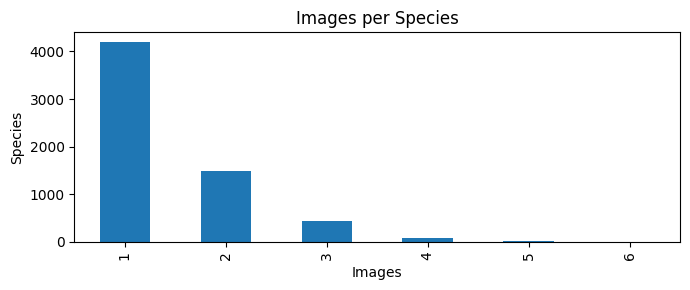

In [5]:
species_counts = train['species'].value_counts()
count_summary = species_counts.value_counts().sort_index()
count_summary.plot(kind='bar', figsize=(7, 3))

plt.title('Images per Species')
plt.xlabel('Images')
plt.ylabel('Species')
plt.tight_layout() 
plt.show()

In [6]:
if CONFIG.BUILD_VALID_SET is True:
    unique_species = train['species'].unique()
    n_test_species_exclusive = 2

    # Randomly pick exclusive test species
    test_species_exclusive = np.random.choice(unique_species, n_test_species_exclusive, replace=False)

    # Isolate exclusive test species data
    exclusive_test_set = train[train['species'].isin(test_species_exclusive)]

    # Remove exclusive test species from main data
    train_reduced = train[~train['species'].isin(test_species_exclusive)]
    print(len(train_reduced))
    test_set_common = pd.DataFrame()
    for species in train_reduced['species'].unique():
        species_data = train_reduced[train_reduced['species'] == species]
        sample = species_data.sample(1, random_state=42) 
        test_set_common = pd.concat([test_set_common, sample])

    # Remove these samples from train
    train_set = train_reduced.drop(test_set_common.index)

    valid_set = pd.concat([exclusive_test_set, test_set_common])
#     train_set.to_pickle('train_set.pkl')
#     valid_set.to_pickle('valid_set.pkl')
    
    print(f"Training set size: {len(train_set)}")
    print(f"Valid set size: {len(final_test_set)}")
    print(f"Unique species in Training set: {train_set['species'].nunique()}")
    print(f"Unique species in Valid set: {final_test_set['species'].nunique()}")
    train = train_set
elif CONFIG.USE_VALID_SET is True:
    valid_set = pd.read_pickle('/kaggle/input/dataset-with-validation/valid_set.pkl')
    

In [7]:
def create_small_dataset(train):
    small_dataset = train.sample(n=10000)
    small_dataset.to_pickle('small_train.pkl')
# create_small_dataset(train_set)

In [8]:
LOG_FEATURES = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']

y_train = np.zeros_like(train[CONFIG.TARGET_COLUMNS], dtype=np.float32)
for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
    v = train[target].values
    if target in LOG_FEATURES:
        v = np.log10(v)
    y_train[:, target_idx] = v

SCALER = StandardScaler()
y_train = SCALER.fit_transform(y_train)

In [9]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

TRAIN_TRANSFORMS = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomSizedCrop(
            [448, 512],
            CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE, w2h_ratio=1.0, p=0.75),
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.25),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

TEST_TRANSFORMS = A.Compose([
        A.Resize(CONFIG.IMAGE_SIZE, CONFIG.IMAGE_SIZE),
        A.ToFloat(),
        A.Normalize(mean=MEAN, std=STD, max_pixel_value=1),
        ToTensorV2(),
    ])

class Dataset(Dataset):
    def __init__(self, X_jpeg_bytes, y, transforms=None):
        self.X_jpeg_bytes = X_jpeg_bytes
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.X_jpeg_bytes)

    def __getitem__(self, index):
        X_sample = self.transforms(
            image=imageio.imread(self.X_jpeg_bytes[index]),
        )['image']

        y_sample = self.y[index]
  
        return X_sample, y_sample

    
if CONFIG.USE_VALID_SET is True:
    y_valid = np.zeros_like(valid_set[CONFIG.TARGET_COLUMNS], dtype=np.float32)
    for target_idx, target in enumerate(CONFIG.TARGET_COLUMNS):
        v = valid_set[target].values
        if target in LOG_FEATURES:
            v = np.log10(v)
        y_valid[:, target_idx] = v

    SCALER = StandardScaler()
    y_valid = SCALER.fit_transform(y_valid)
    valid_dataset = Dataset( 
        valid_set['jpeg_bytes'].values,
        y_valid,
        TEST_TRANSFORMS,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        shuffle=False,
        batch_size=CONFIG.BATCH_SIZE,
        num_workers=psutil.cpu_count(),
)

    
train_dataset = Dataset(
    train['jpeg_bytes'].values,
    y_train,
    TRAIN_TRANSFORMS,
)

train_dataloader = DataLoader(
        train_dataset,
        batch_size=CONFIG.BATCH_SIZE,
        shuffle=True,
        drop_last=True,
        num_workers=psutil.cpu_count(),
)

test_dataset = Dataset(
    test['jpeg_bytes'].values,
    test['id'].values,
    TEST_TRANSFORMS,
)   

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
                CONFIG.BACKBONE,
                num_classes=CONFIG.N_TARGETS,
                pretrained=True)
        
    def forward(self, inputs):
        return self.backbone(inputs)

model = Model()
model = model.to('cuda')
# print(model)

model.safetensors:   0%|          | 0.00/801M [00:00<?, ?B/s]

In [11]:
def get_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer,
        max_lr=CONFIG.LR_MAX,
        total_steps=CONFIG.N_STEPS,
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e1,
        final_div_factor=1e1,
    )

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.sum += val.sum()
        self.count += val.numel()
        self.avg = self.sum / self.count

MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
LOSS = AverageMeter()

Y_MEAN = torch.tensor(y_train).mean(dim=0).to('cuda')
EPS = torch.tensor([1e-6]).to('cuda')

def r2_loss(y_pred, y_true):
    ss_res = torch.sum((y_true - y_pred)**2, dim=0)
    ss_total = torch.sum((y_true - Y_MEAN)**2, dim=0)
    ss_total = torch.maximum(ss_total, EPS)
    r2 = torch.mean(ss_res / ss_total)
    return r2

LOSS_FN = nn.SmoothL1Loss() # r2_loss

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=CONFIG.LR_MAX,
    weight_decay=CONFIG.WEIGHT_DECAY,
)

LR_SCHEDULER = get_lr_scheduler(optimizer)

In [12]:
if CONFIG.TRAIN_MODEL is True:
    print("Start Training:")
    for epoch in range(CONFIG.N_EPOCHS):
        MAE.reset()
        R2.reset()
        LOSS.reset()
        model.train()

        for step, (X_batch, y_true) in enumerate(train_dataloader):
            X_batch = X_batch.to('cuda')
            y_true = y_true.to('cuda')
            t_start = time.perf_counter_ns()
            y_pred = model(X_batch)
            loss = LOSS_FN(y_pred, y_true)
            LOSS.update(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            LR_SCHEDULER.step()
            MAE.update(y_pred, y_true)
            R2.update(y_pred, y_true)

            if not CONFIG.IS_INTERACTIVE and (step+1) == CONFIG.N_STEPS_PER_EPOCH:
                print(
                    f'EPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                )
            elif CONFIG.IS_INTERACTIVE:
                print(
                    f'\rEPOCH {epoch+1:02d}, {step+1:04d}/{CONFIG.N_STEPS_PER_EPOCH} | ' + 
                    f'loss: {LOSS.avg:.4f}, mae: {MAE.compute().item():.4f}, r2: {R2.compute().item():.4f}, ' +
                    f'step: {(time.perf_counter_ns()-t_start)*1e-9:.3f}s, lr: {LR_SCHEDULER.get_last_lr()[0]:.2e}',
                    end='\n' if (step + 1) == CONFIG.N_STEPS_PER_EPOCH else '', flush=True,
                )

    torch.save(model, 'model.pth')
else:
    model = torch.load('/kaggle/input/baseline-model/model.pth')

Start Training:
EPOCH 01, 0885/885 | loss: 0.3203, mae: 0.6649, r2: 0.2747, step: 1.356s, lr: 9.87e-05
EPOCH 02, 0885/885 | loss: 0.2518, mae: 0.5724, r2: 0.4425, step: 1.249s, lr: 8.45e-05
EPOCH 03, 0885/885 | loss: 0.1876, mae: 0.4798, r2: 0.5952, step: 1.245s, lr: 5.91e-05
EPOCH 04, 0885/885 | loss: 0.1224, mae: 0.3772, r2: 0.7436, step: 1.245s, lr: 3.09e-05
EPOCH 05, 0885/885 | loss: 0.0756, mae: 0.2919, r2: 0.8452, step: 1.242s, lr: 9.14e-06
EPOCH 06, 0885/885 | loss: 0.0541, mae: 0.2455, r2: 0.8899, step: 1.244s, lr: 1.00e-06


### Evaluation of the model

In [13]:
model.eval()  # Set the model to evaluation mode
test_MAE = torchmetrics.regression.MeanAbsoluteError().to('cuda')
test_R2 = torchmetrics.regression.R2Score(num_outputs=CONFIG.N_TARGETS, multioutput='uniform_average').to('cuda')
test_loss = AverageMeter()

with torch.no_grad():  # Disable gradient computation for evaluation
    for X_batch, y_true in valid_dataloader:
        X_batch = X_batch.to('cuda')
        y_true = y_true.to('cuda')
        
        # Predict and evaluate
        y_pred = model(X_batch)
        loss = LOSS_FN(y_pred, y_true)
        test_loss.update(loss)
        test_MAE.update(y_pred, y_true)
        test_R2.update(y_pred, y_true)

# Print test results
print(
    f'Test Results - Loss: {test_loss.avg:.4f}, MAE: {test_MAE.compute().item():.4f}, ' +
    f'R2: {test_R2.compute().item():.4f}'
)

Test Results - Loss: 0.2533, MAE: 0.5684, R2: 0.4287


In [14]:
SUBMISSION_ROWS = []
model.eval()

for X_sample_test, test_id in tqdm(test_dataset):
    with torch.no_grad():
        y_pred = model(X_sample_test.unsqueeze(0).to('cuda')).detach().cpu().numpy()
    
    y_pred = SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': test_id}
    
    for k, v in zip(CONFIG.TARGET_COLUMNS, y_pred):
        if k in LOG_FEATURES:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)
    
submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df.to_csv('submission.csv', index=False)
print("Submit!")

  0%|          | 0/6545 [00:00<?, ?it/s]

Submit!
